# Explicação
Nesse arquivo há:
- Limpeza de dados usados para a classificação.
- Uma breve análise desses dados.

In [1]:
from astropy.stats import sigma_clip, mad_std
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# From: https://github.com/marixko/MNRAS_nakazono_2021

def apply_sigma_clip(data, mag_splus, mag_sdss, sigma_value=4):
    '''
    Apply n-sigma clipping on the S-PLUS and SDSS magnitude difference per 
    magnitude (from S-PLUS) bin of size 0.5 
    
    Keywords arguments:
    data -- full dataset
    mag_splus -- magnitude from S-PLUS
    mag_sdss -- magnitude from SDSS
    sigma_value -- value of n (default: 4)
    create_plot -- determine if plot of mag_sdss - mag_splus x mag_splus is created
    
    returns a subset from data that pass through n-sigma clipping
    '''
    aux2 = data
    final_data = pd.DataFrame([])
    for i in np.arange(np.floor(np.min(data.query(mag_splus+'!=99 and '+mag_splus+'!=-99')[mag_splus])), np.ceil(np.max(data.query(mag_splus+'!=99 and '+mag_splus+'!=-99')[mag_splus])), 0.5):
        aux = aux2[(aux2[mag_splus] > i) & (aux2[mag_splus] <= i+0.5)].query(mag_sdss+'< 90 and '+mag_sdss+"> -90 and "+mag_splus+" <90")
        filtered_data = sigma_clip(
            aux[mag_sdss]-aux[mag_splus], sigma=sigma_value, maxiters=5, stdfunc=mad_std, return_bounds=True)
        if len(filtered_data) != 0:
            final_data = pd.concat(
                [final_data, aux[filtered_data[0].mask == False]], axis=0)

    return final_data

In [3]:
QSO = Table.read("raw_tables/QSO_S82_iDR4.fits", format='fits')
QSO = QSO.to_pandas().assign(target=0).rename(columns={"r":"modelmag_r"})

STAR = Table.read("raw_tables/STAR_S82_iDR4.fits", format='fits')
STAR = STAR.to_pandas().assign(target=1)

GAL = Table.read("raw_tables/GALAXY_S82_iDR4.fits", format='fits')
GAL = GAL.to_pandas().assign(target=2)

In [4]:
columns = ['ID', 'A', 'B', 'KRON_RADIUS','RA_1', 'DEC_1', 'u_iso', 'J0378_iso', 'J0395_iso', 'J0410_iso', 'J0430_iso',
       'g_iso', 'J0515_iso', 'r_iso', 'J0660_iso', 'i_iso',
       'J0861_iso', 'z_iso', 'target', 'e_r_iso', 'FWHM_n', 'w1mpro', 'w2mpro'] 

QSO = QSO[(QSO['SEX_FLAGS_r'] == 0) & (QSO['r_iso']<=22)]
STAR = STAR[(STAR['SEX_FLAGS_r'] == 0) & (STAR['r_iso']<=22) & (STAR['r_iso']>13)]
GAL = GAL[(GAL['SEX_FLAGS_r'] == 0) & (GAL['r_iso']<=22) & (GAL['zWarning']==0)]

total = pd.concat([QSO,STAR,GAL])
total = apply_sigma_clip(total, 'r_iso', 'modelmag_r',)
total = total[columns].reset_index().drop(columns='index')

### Observação:
Aqui, eu utilizo as magnitudes do wise para obter a mesma divisão treino/testo do classificador atual do DR4.
O processo utilizado antes foi o seguinte:
 - Separar os dados em dois conjuntos disjuntos: os que possuem observação no WISE e os que não possuem.
 - Para cada conjunto, separar treino/teste com 25% para teste.
 - Unir, novamente, os conjuntos.

Como eu não tenho nenhuma garantia (e, por uma observação feita enquanto reproduzia o artigo da Lilianne, tenho conviccção de que não) de que $split(a) + split(b) = split(a+b)$, vou usar as colunas do WISE para fazer o mesmo processo. Embora o WISE não possua significado nesse contexto, farei isso apenas para assegurar a mesma divisão.

In [5]:
from sklearn.model_selection import train_test_split

with_wise = total[~total["w1mpro"].isna() & ~total["w2mpro"].isna()] 

target = with_wise["target"]
X_train_wise, X_test_wise, y_train_wise, y_test_wise = train_test_split(with_wise, target,test_size=0.25,random_state=2,stratify=target)

In [6]:
no_wise =  total.merge(with_wise, how='left', indicator=True)
no_wise = no_wise[no_wise['_merge'] == 'left_only']
target = no_wise["target"]
X_train_no_wise, X_test_no_wise, y_train_no_wise, y_test_no_wise = train_test_split(no_wise, target,test_size=0.25,random_state=2,stratify=target)

In [7]:
X_train_total = pd.concat([X_train_wise,X_train_no_wise]).assign(test=0)
X_test_total = pd.concat([X_test_wise, X_test_no_wise]).assign(test=1, train=0, validation=0, split="test")

### Observações: 
Agora, temos a seguinte propriedade: \
Para um objeto $o$, se $o['test'] = 1$, então $o$ estava no conjunto de testes do modelo treinado para o DR4. A recíproca também vale.


Agora, irei definir um conjunto de validação. Esse conjunto não está relacionado com o modelo treinado para o DR4, então não precisarei utilizar as informações do WISE. O conjunto de validação pegará 20% de X_train_total (que possui 75% de todos os dados). \
\
Logo, o split será:
 - Treino: 60%
 - Validação: 15%
 - Teste: 25%

Esse split é apenas inicial e pode mudar no futuro.



In [8]:
target = X_train_total["target"]
X_train, X_val, y_train, y_val = train_test_split(X_train_total, target,test_size=0.20,random_state=2,stratify=target)

In [9]:
X_train = X_train.assign( train=1, validation=0, split="train")
X_val = X_val.assign(train=0, validation=1, split="val")

In [10]:
final = pd.concat([X_train, X_val, X_test_total]).drop(columns="_merge")

In [11]:
final['ID'] = final['ID'].str.decode('utf-8').str[2:30] 
final = final.drop_duplicates(subset="ID") # Retira uma versão de objetos com classificação multipla
final = final[(final.ID != 'iDR4_3_STRIPE82-0066_0044492')
             &(final.ID != 'iDR4_3_STRIPE82-0046_0029265')]# Retira dois objetos que (por algum motivo) não estão sendo baixados.

### Split 90/5/5

In [13]:
from sklearn.model_selection import train_test_split
target = total["target"]
train, test = train_test_split(total, test_size=0.1,random_state=2, stratify=target)
target = test["target"]
test, val = train_test_split(test, test_size=0.5,random_state=2, stratify=target)
train = train.assign(split="train", train=1, test=0, validation=0)
test = test.assign(split="test", train=0, test=1, validation=0)
val = val.assign(split="val", train=0, test=0, validation=1)
final = pd.concat([train,test,val]) 

## Visualizações:

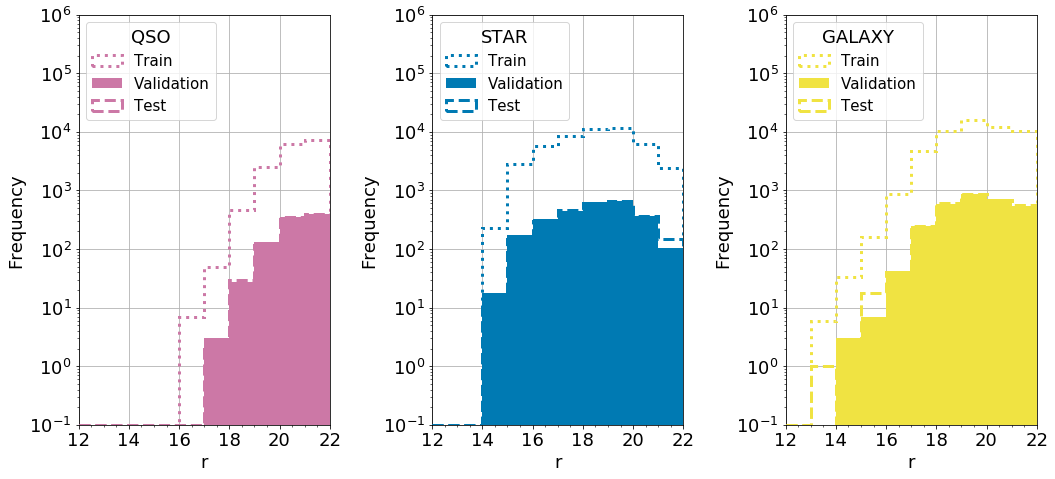

In [14]:
# Adaptado de https://github.com/marixko/MNRAS_nakazono_2021/blob/main/Nakazono_et_al_2021.ipynb

blue = (0, 0.48, 0.70)
orange = (230/255,159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)

plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,3, figsize=(15,7))

bins = np.arange(12,22.1,1)
log = True
density = False
ax[0].hist(final[(final.target==0) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=pink, log=log, density=density, label="Train", zorder=3)
ax[0].hist(final[(final.target==0) & (final.validation==1)].r_iso, bins=bins, color=pink, log=log, density=density, label="Validation", zorder=3)
ax[0].hist(final[(final.target==0) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=pink, log=log, density=density, label="Test", zorder=3)

ax[1].hist(final[(final.target==1) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=blue, log=log, density=density, label="Train", zorder=3)
ax[1].hist(final[(final.target==1) & (final.validation==1)].r_iso, bins=bins, color=blue, log=log, density=density, label="Validation", zorder=3)
ax[1].hist(final[(final.target==1) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=blue, log=log, density=density, label="Test", zorder=3)


ax[2].hist(final[(final.target==2) & (final.train==1)].r_iso, histtype="step", linewidth=3, linestyle="dotted", bins=bins,
             color=yellow, log=log, density=density, label="Train", zorder=3)
ax[2].hist(final[(final.target==2)& (final.validation==1)].r_iso, bins=bins, color=yellow, log=log, density=density, label="Validation", zorder=3)
ax[2].hist(final[(final.target==2) & (final.test==1)].r_iso, histtype="step", linewidth=3, linestyle="dashed", bins=bins,
             color=yellow, log=log, density=density, label="Test", zorder=3)



for j in [0,1,2]:
    if j == 0:
        title="QSO"
    elif j == 1:
        title="STAR"
    else:
        title ="GALAXY"
    
    ax[j].minorticks_on()
    ax[j].grid(zorder=0)
    ax[j].set_xticks(np.arange(12,22.1,2))
    ax[j].legend(loc="upper left", title=title, prop={'size': 15}, title_fontsize=18)
        
plt.setp(ax, xlim=(12,22), ylim=(0.1,1000000) ,xlabel='r', ylabel = "Frequency")
plt.tight_layout()

In [13]:
print(f"Existem {len(final[final.r_iso<=14])} objetos com magnitude <= 14")
for i in range(15,23):
    x = len(final[(final.r_iso>i-1)&(final.r_iso<=i)])
    print(f"Existem {x} objetos com magnitude {i-1}<r<={i} ({x/len(final)*100}%)")

Existem 7 objetos com magnitude <= 14
Existem 291 objetos com magnitude 14<r<=15 (0.21858169772629968%)
Existem 3308 objetos com magnitude 15<r<=16 (2.4847706394453586%)
Existem 7327 objetos com magnitude 16<r<=17 (5.503601715603428%)
Existem 14803 objetos com magnitude 17<r<=18 (11.119123269561559%)
Existem 24564 objetos com magnitude 18<r<=19 (18.450999391576715%)
Existem 33546 objetos com magnitude 19<r<=20 (25.197737566757556%)
Existem 27330 objetos com magnitude 20<r<=21 (20.52865222975866%)
Existem 21955 objetos com magnitude 21<r<=22 (16.491275510587318%)


## Análise da Distribuição de magnitude

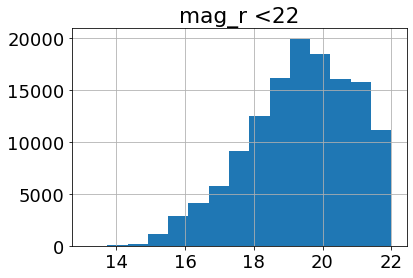

In [10]:
plt.title("mag_r <22")
total.r_iso.hist(bins=15)

In [16]:
teste = total[total.e_r_iso <0.05]
print(f"{len(total)-len(teste)} objetos foram eliminados")

54650 objetos foram eliminados


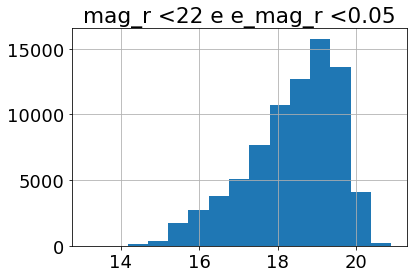

In [17]:
plt.title("mag_r <22 e e_mag_r <0.05")
teste.r_iso.hist(bins=15)

# Salvando em csv

In [24]:
final['ID'] = final['ID'].str.decode('utf-8').str[2:30] 
final = final.drop_duplicates(subset="ID")

In [25]:
final.reset_index().drop(columns='index').to_csv("clf_90_5_5.csv")

In [22]:
temp = final[["FWHM_n","target"]]
len(temp[temp.FWHM_n > 32/3])

36

In [23]:
final

,ID,A,B,KRON_RADIUS,RA_1,DEC_1,u_iso,J0378_iso,J0395_iso,J0410_iso,...,z_iso,target,e_r_iso,FWHM_n,w1mpro,w2mpro,split,train,test,validation
130773,"b""b'iDR4_3_STRIPE82-0045_0028140 ...",0.000234,0.000135,7.728666,31.504410,-0.592362,99.000000,99.000000,22.384966,99.000000,...,20.564034,2,0.207219,2.342879,15.868,15.580000,train,1,0,0
62960,"b""b'iDR4_3_STRIPE82-0071_0006887 ...",0.000391,0.000330,3.916353,49.251016,-1.154209,21.839247,20.898956,20.978590,20.807573,...,18.409325,2,0.032939,1.435171,15.474,15.260000,train,1,0,0
118694,"b""b'iDR4_3_STRIPE82-0031_0038437 ...",0.000215,0.000193,3.367306,21.741788,-0.320973,24.524836,23.539324,22.547157,22.943121,...,20.031553,2,0.099001,1.987406,15.734,15.640000,train,1,0,0
18589,"b""b'iDR4_3_STRIPE82-0032_0002325 ...",0.000293,0.000249,3.886473,21.734358,0.072648,19.509678,19.002240,19.190517,18.818336,...,17.675484,1,0.013031,1.166702,16.344,16.239000,train,1,0,0
29959,"b""b'iDR4_3_STRIPE82-0102_0075218 ...",0.000234,0.000222,3.402106,310.250739,1.012908,22.309560,23.268545,23.008677,21.161547,...,17.264418,1,0.015666,1.062590,15.009,14.974000,train,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11596,"b""b'iDR4_3_STRIPE82-0015_0038006 ...",0.000293,0.000282,3.369621,9.362603,-0.203612,99.000000,99.000000,21.437769,20.420168,...,15.986316,1,0.010527,0.973784,13.654,13.631000,val,0,0,1
109301,"b""b'iDR4_3_STRIPE82-0136_0024875 ...",0.000305,0.000215,7.442614,334.860274,0.836840,24.265427,22.475416,99.000000,99.000000,...,19.753742,2,0.150365,2.048166,15.586,15.491000,val,0,0,1
38429,"b""b'iDR4_3_STRIPE82-0017_0013223 ...",0.000310,0.000268,4.291334,11.682376,-0.978077,19.887972,19.663002,19.501950,19.379640,...,18.501053,1,0.022259,1.169357,16.851,16.688999,val,0,0,1
23274,"b""b'iDR4_3_STRIPE82-0036_0010354 ...",0.000716,0.000285,3.407044,24.505350,0.524798,20.071120,19.623894,20.165972,19.046030,...,17.273480,2,0.031537,4.026918,14.474,14.176000,val,0,0,1
